# Setup/Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import os 

# Convert Bach chorales into wav format

Adapted from https://stackoverflow.com/questions/63974543/how-can-i-play-music-represented-as-chords-in-a-csv-file-with-python


In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))


# Prepare Input

In [3]:
dataset_path = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachChorales/'
# This function concatenates all the notes inside 382 chorales
def readfiles():
    count = 0
    #Initialise List
    X = []
    for folder, subfolder, files in os.walk(dataset_path):
        #Read the files and assign to List declared before
        print(folder)
        print(len(files))
        for file in files:
            df = pd.read_csv(os.path.join(folder, file))
            X.append(df.values.tolist())
            count = count +1
    return X,count

In [4]:
dataset,count = readfiles()
trainset = dataset[:340]
validset = dataset[341:371]
testset = dataset[372:]

/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachChorales/
0
/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachChorales/valid
76
/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachChorales/test
77
/content/drive/Shareddrives/EC523_Project/CodeWorkspace/BachChorales/train
229


# Processing Functions

To obtain a larger training set, we used the window
method to create a dataset with shorter character windows. We set the sindow size to be 32, and 16 for the shift, so that the fist window contain the 0th to 32nd chord, the second windowcontained the 16th to 48th chords, and so on. Since the chords for each time step are treated as arpeggios (4 notes sounded in
sequence), the notes in each window are equal to the number of
chords multiplied by 4 to 128 notes. To ensure that no padding is
required to create the batch, We drop the remainder that could not fit into a batch

In [9]:
from pandas.core.internals.construction import dataclasses_to_dicts
import itertools
# This function creates a window size of 32 chords (128 notes) and shifting 16 chords to obtain a larger training size
def windowing(dataset,window_size,shift):
    window = []
    for i in range(0,len(dataset)):
        data = dataset[i]
        r = len(data)%16
        if r != 0:
            data = data[:-r]
        for j in range(0,len(data),shift):
            win = list(itertools.chain.from_iterable(data[j:j+window_size]))
            if len(win) == window_size*4:
                window.append(win)
    return window 


In [10]:
# This function separates the dataset into input (first 127 notes) and output (last notes)
def Preprocess(dataset):
    X = np.zeros((len(dataset),127))
    y = np.zeros(len(dataset))

    for i in range(len(dataset)):
      data = np.array(dataset[i])-35
      data[data < 0 ] = 0
      y[i] = data[-1]
      X[i] = data[:-1]
    return X,y 


In [11]:
# We prepare the training and validation set for training the WaveNet + LSTM model 
window_size = 32
shift = 16
train = windowing(trainset,window_size,shift)
X_train,y_train = Preprocess(train)
valid = windowing(validset,window_size,shift)
X_valid,y_valid = Preprocess(valid)

print(X_train.shape)
print(X_valid.shape)



(4762, 127)
(408, 127)


# WaveNet Model

The model starts with an embedding layer, the main structure being a small WaveNet interspersed with a BatchNormalization layer, followed by an LSTM
layer, and finally passing through a dense layer and activated by
SoftMax to predict the probability of each note.

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

In [ ]:
model = Sequential()
vocab = list(range(36,81))
vocab.append(0)
    
#model.add(Embedding(len(vocab), 5,input_length=128, trainable=True)) 
model.add(Embedding(input_dim=47,output_dim=5,input_length=127,trainable=True))

model.add(Conv1D(32,3, padding='causal',activation='relu'))
#model.add(Dropout(0.2))
#model.add(MaxPool1D(2))
model.add(BatchNormalization())
    
model.add(Conv1D(48,3,activation='relu',dilation_rate=2,padding='causal'))
#model.add(Dropout(0.2))
#model.add(MaxPool1D(2))
model.add(BatchNormalization())

model.add(Conv1D(64,3,activation='relu',dilation_rate=4,padding='causal'))
#model.add(Dropout(0.2))
#model.add(MaxPool1D(2))
model.add(BatchNormalization())

model.add(Conv1D(96,3, activation='relu',dilation_rate=8,padding='causal'))
#model.add(Dropout(0.2))
#model.add(MaxPool1D(2))
model.add(BatchNormalization())
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=16,padding='causal'))
#model.add(Dropout(0.2))
#model.add(MaxPool1D(2))
model.add(BatchNormalization())

model.add(Conv1D(256,3,activation='relu',dilation_rate=32,padding='causal'))
#model.add(Dropout(0.2))
#model.add(MaxPool1D(2))
model.add(BatchNormalization())

model.add(LSTM(256))         
#model.add(GlobalMaxPool1D())
    
#model.add(Dense(256, activation='relu'))
model.add(Dense(len(vocab), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 127, 5)            235       
                                                                 
 conv1d_6 (Conv1D)           (None, 127, 32)           512       
                                                                 
 batch_normalization_6 (Batc  (None, 127, 32)          128       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 127, 48)           4656      
                                                                 
 batch_normalization_7 (Batc  (None, 127, 48)          192       
 hNormalization)                                                 
                                                                 
 conv1d_8 (Conv1D)           (None, 127, 64)          

In [ ]:
# We trained the model and kept the best performance model 
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(X_train,y_train,batch_size=128,epochs=50, validation_data= (X_valid,y_valid), verbose=1, callbacks = [mc])



Epoch 1/50
31/32 [============================>.] - ETA: 0s - loss: 2.7134
Epoch 1: val_loss improved from inf to 4.66691, saving model to best_model.h5
32/32 [==============================] - 9s 82ms/step - loss: 2.6910 - val_loss: 4.6669
Epoch 2/50
31/32 [============================>.] - ETA: 0s - loss: 1.4507
Epoch 2: val_loss did not improve from 4.66691
32/32 [==============================] - 1s 39ms/step - loss: 1.4458 - val_loss: 5.0740
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.6351
Epoch 3: val_loss did not improve from 4.66691
32/32 [==============================] - 1s 42ms/step - loss: 0.6351 - val_loss: 5.0427
Epoch 4/50
31/32 [============================>.] - ETA: 0s - loss: 0.2366
Epoch 4: val_loss did not improve from 4.66691
32/32 [==============================] - 1s 39ms/step - loss: 0.2391 - val_loss: 4.9361
Epoch 5/50
31/32 [============================>.] - ETA: 0s - loss: 0.0768
Epoch 5: val_loss did not improve from 4.66691
32/32 [

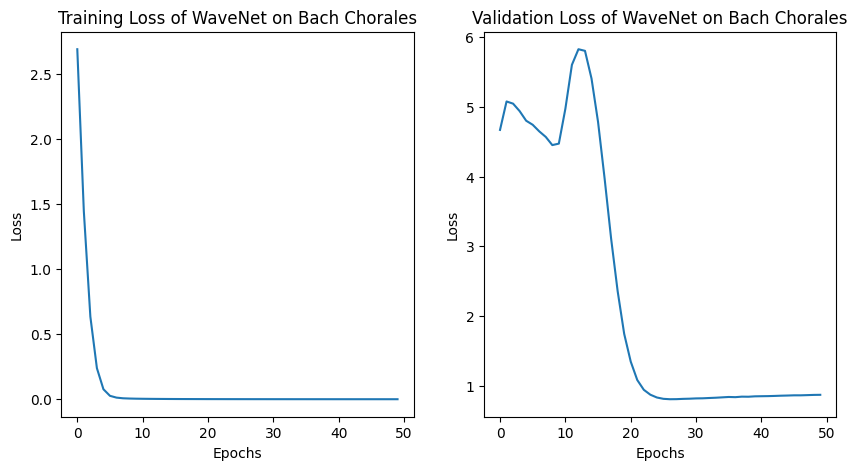

In [ ]:
# We plotted the training loss and validation loss 
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.plot(training_loss)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss of WaveNet on Bach Chorales')

ax2.plot(validation_loss)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss of WaveNet on Bach Chorales')

plt.show()

In [ ]:
# Save Model
PATH = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/models/model_WaveNet.pth'
model.save(PATH)

# Testing

In [5]:
# Load Model
from tensorflow import keras
PATH = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/models/model_WaveNet.pth'
model = keras.models.load_model(PATH)

In [57]:
# Prepare the seed chord 



In [12]:
def Generate_Bach(dataset,top_k,window_size,shift = 16):
    # Prepare the seed chord 
    test =  windowing(dataset,window_size,shift)
    sample = np.zeros((len(test),len(test[0])))
    # generate range for embedding
    for i in range(len(test)):
        sample[i] = np.array(test[i])-35
        sample[sample<0] = 0 
    for i in range(0,window_size*3,4):
        out = model.predict(sample[:,i:i+127])
        out = out.argsort(axis = -1)
        rand = np.random.randint(1,top_k+1)
        out = out[:,-rand]
        sample[:,i+128] = out
    sample = sample+35
    sample[sample == 0]=0

    sample = np.reshape(sample,(len(sample),len(sample[0])//4,4))
    return sample 

In [14]:
# sample1 = Generate_Bach(testset,top_k = 1,window_size = 128,shift = 16)
# sample3 = Generate_Bach(testset,top_k = 3,window_size = 128,shift = 16)
# sample5 = Generate_Bach(testset,top_k = 5,window_size = 128,shift = 16)
sample10 = Generate_Bach(testset,top_k = 10,window_size = 128,shift = 16)
sample30 = Generate_Bach(testset,top_k = 30,window_size = 128,shift = 16)

2/2 [==============================] - 0s 9ms/step


# Music Generation

In [16]:
# Play and Save samples

for i in range(len(sample30)) :
  # Save as CSV
  SAVE_PATH = f'/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/WaveNet_30/{i}.csv'
  pd.DataFrame(sample30[i,:,:], columns =['note0','note1','note2','note3']).to_csv(SAVE_PATH,index=False)
  # #generate music
  # play_chords(sample[i,:,:],filepath=None)

In [ ]:
play_chords(sample[i,:,:],filepath='/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/song_bach_1.wav')